In [1]:
from robotreboot_env import RobotRebootEnv
from models.robotreboot import RobotReboot
from models.maze import Maze
from models.robotreboot import Goal
from models.instance_game import get_robot_reboot

import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
robot_reboot = get_robot_reboot()
env = RobotRebootEnv(robot_reboot)

### Playing with the environment

In [3]:
env.reset()

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [8., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0.,

In [4]:
env.action_space

Discrete(16)

In [5]:
obs, reward, done, info = env.step('A_N')

In [6]:
obs.shape

(16, 16, 5)

In [7]:
env.actions

['A_N',
 'A_S',
 'A_E',
 'A_W',
 'G_N',
 'G_S',
 'G_E',
 'G_W',
 'B_N',
 'B_S',
 'B_E',
 'B_W',
 'R_N',
 'R_S',
 'R_E',
 'R_W']

### Deep Q-Learning

In [8]:
input_shape = env.state.size
n_outputs = len(env.actions)
print(f'input_shape = {input_shape}\nn_outputs = {n_outputs}')

input_shape = 1280
n_outputs = 16


In [9]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape = env.state.shape),
    keras.layers.MaxPooling2D(4),
#     keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape = env.state.shape),
#     keras.layers.MaxPooling2D(4),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_outputs, activation='softmax')
])

In [10]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else :
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [11]:
from collections import deque

replay_buffer = deque(maxlen=20000)

In [12]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [13]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(env.actions[action])
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [14]:
batch_size = 64
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

In [15]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1-dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values =tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [16]:
dones = list()
rewards = list()
for episode in range(1000):
    obs = env.reset()
    if episode % 20 == 0:
        print(episode)
    current_reward = 0
    for step in range(600):
        epsilon = max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        current_reward += reward
        if done:
            dones.append(env.robot_reboot.current_game)
            break
#         if episode > 10:
        training_step(batch_size)
    rewards.append(current_reward)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


### Rewards plot

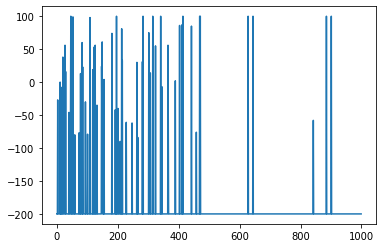

In [17]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.show()

### Save results

In [18]:
import json
index = 0
done_games = []
for i in dones:
    state_file = f'data/done_games/state_{index}.npy'
    np.save(state_file, i.initial_state)
    done_games.append({
        "index": index,
        "state_file": state_file,
        "movements": i.movements
    })
    index += 1

In [19]:
dones_obj = {
    "robots": [i for i in env.robot_reboot.robots],
    "games": done_games
}
with open('data/done_games/result.json', 'w') as file:
    json.dump(dones_obj, file)

In [20]:
robot_maze = dones[0].initial_state[:, : , 1]
robot_maze

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [21]:
x, y = np.where(robot_maze == 100)

In [22]:
env.robot_reboot.state

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       ...,

       [[4., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [8., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0.,

In [23]:
dones[0].movements

[('G', 'S'),
 ('A', 'W'),
 ('A', 'N'),
 ('B', 'N'),
 ('B', 'W'),
 ('A', 'S'),
 ('A', 'W'),
 ('G', 'W'),
 ('B', 'N'),
 ('G', 'E'),
 ('G', 'S'),
 ('A', 'N'),
 ('A', 'E'),
 ('G', 'S'),
 ('G', 'N'),
 ('G', 'E'),
 ('B', 'N'),
 ('B', 'N'),
 ('G', 'S'),
 ('A', 'S'),
 ('G', 'N'),
 ('B', 'N'),
 ('B', 'N'),
 ('G', 'N'),
 ('A', 'S'),
 ('A', 'N'),
 ('G', 'W'),
 ('R', 'W'),
 ('R', 'S'),
 ('A', 'E'),
 ('A', 'W'),
 ('A', 'N'),
 ('A', 'W'),
 ('B', 'S'),
 ('A', 'W'),
 ('B', 'N'),
 ('B', 'W'),
 ('B', 'W'),
 ('B', 'W'),
 ('G', 'E'),
 ('G', 'E'),
 ('A', 'W'),
 ('A', 'N'),
 ('B', 'W'),
 ('R', 'W'),
 ('A', 'S'),
 ('A', 'E'),
 ('R', 'N'),
 ('A', 'W'),
 ('R', 'S'),
 ('A', 'S'),
 ('A', 'S'),
 ('G', 'E'),
 ('G', 'S'),
 ('B', 'E'),
 ('G', 'N'),
 ('A', 'N'),
 ('B', 'W'),
 ('A', 'E'),
 ('R', 'S'),
 ('A', 'S'),
 ('G', 'N'),
 ('R', 'N'),
 ('B', 'W'),
 ('B', 'E'),
 ('B', 'W'),
 ('G', 'W'),
 ('R', 'W'),
 ('R', 'N'),
 ('G', 'S'),
 ('A', 'E'),
 ('G', 'W'),
 ('G', 'E'),
 ('R', 'N'),
 ('G', 'N'),
 ('B', 'W'),
 ('A', 'E'),